# Transformers Part 1

Data Exploration and Time Series Properties

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries

# Do not show specific warnings from statsmodels
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

## Load Time Series Data

In [2]:
# Load the data frame
# Weather data derived from DWD climate data summary with daily measurements for station 02932 (Leipzig)
df_raw = pd.read_csv("data/dwd_02932_climate.csv", sep=";", parse_dates=["date"], index_col="date")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18263 entries, 1975-01-01 to 2024-12-31
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wind_gust_max              18006 non-null  float64
 1   wind_speed                 18240 non-null  float64
 2   precipitation_height       18263 non-null  float64
 3   precipitation_form         18263 non-null  float64
 4   sunshine_duration          18082 non-null  float64
 5   snow_depth                 18233 non-null  float64
 6   cloud_cover_total          18263 non-null  float64
 7   pressure_vapor             18263 non-null  float64
 8   pressure_air_site          18263 non-null  float64
 9   temperature_air_mean_2m    18263 non-null  float64
 10  humidity                   18263 non-null  float64
 11  temperature_air_max_2m     18263 non-null  float64
 12  temperature_air_min_2m     18263 non-null  float64
 13  temperature_air_min_0_05m  18

In [3]:
# Descriptive statistics
df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wind_gust_max,18006.0,10.788287,4.202323,0.0,7.7,10.0,13.0,37.0
wind_speed,18240.0,4.265318,1.956730,0.0,2.8,3.9,5.3,16.8
precipitation_height,18263.0,1.424624,3.676162,0.0,0.0,0.0,1.1,77.1
precipitation_form,18263.0,3.747303,3.119800,0.0,0.0,6.0,6.0,8.0
sunshine_duration,18082.0,4.692724,4.348312,0.0,0.4,3.8,7.9,15.9
snow_depth,18233.0,0.489168,2.502391,0.0,0.0,0.0,0.0,43.0
cloud_cover_total,18263.0,5.274577,2.118593,0.0,4.0,5.7,7.0,8.0
pressure_vapor,18263.0,9.728418,3.975340,1.0,6.5,9.2,12.6,25.7
pressure_air_site,18263.0,999.611859,8.812704,951.2,994.3,1000.0,1005.3,1029.0
temperature_air_mean_2m,18263.0,9.733313,7.702433,-21.9,3.9,9.9,15.8,30.2


In [4]:
# Check for missing values
print('Missing values:')
print(df_raw.isna().sum())
# Drop temperature related columns except temperature_air_min_2m (our target)
df = df_raw.drop(columns=["temperature_air_max_2m", "temperature_air_min_2m", "temperature_air_min_0_05m"])
# Interpolate for each series with missing values
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f"Interpolating missing values for {col}")
        # Interpolate using linear method
        df[col] = df[col].interpolate(method="linear", limit_direction="both")

Missing values:
wind_gust_max                257
wind_speed                    23
precipitation_height           0
precipitation_form             0
sunshine_duration            181
snow_depth                    30
cloud_cover_total              0
pressure_vapor                 0
pressure_air_site              0
temperature_air_mean_2m        0
humidity                       0
temperature_air_max_2m         0
temperature_air_min_2m         0
temperature_air_min_0_05m      0
dtype: int64
Interpolating missing values for wind_gust_max
Interpolating missing values for wind_speed
Interpolating missing values for sunshine_duration
Interpolating missing values for snow_depth


## Plotting and Decomposition

Visualizing a time series helps us intuitively understand its components. Decomposition splits the series into trend, seasonality, and residuals. This helps us detect patterns, understand structure, and identify what needs to be modeled.

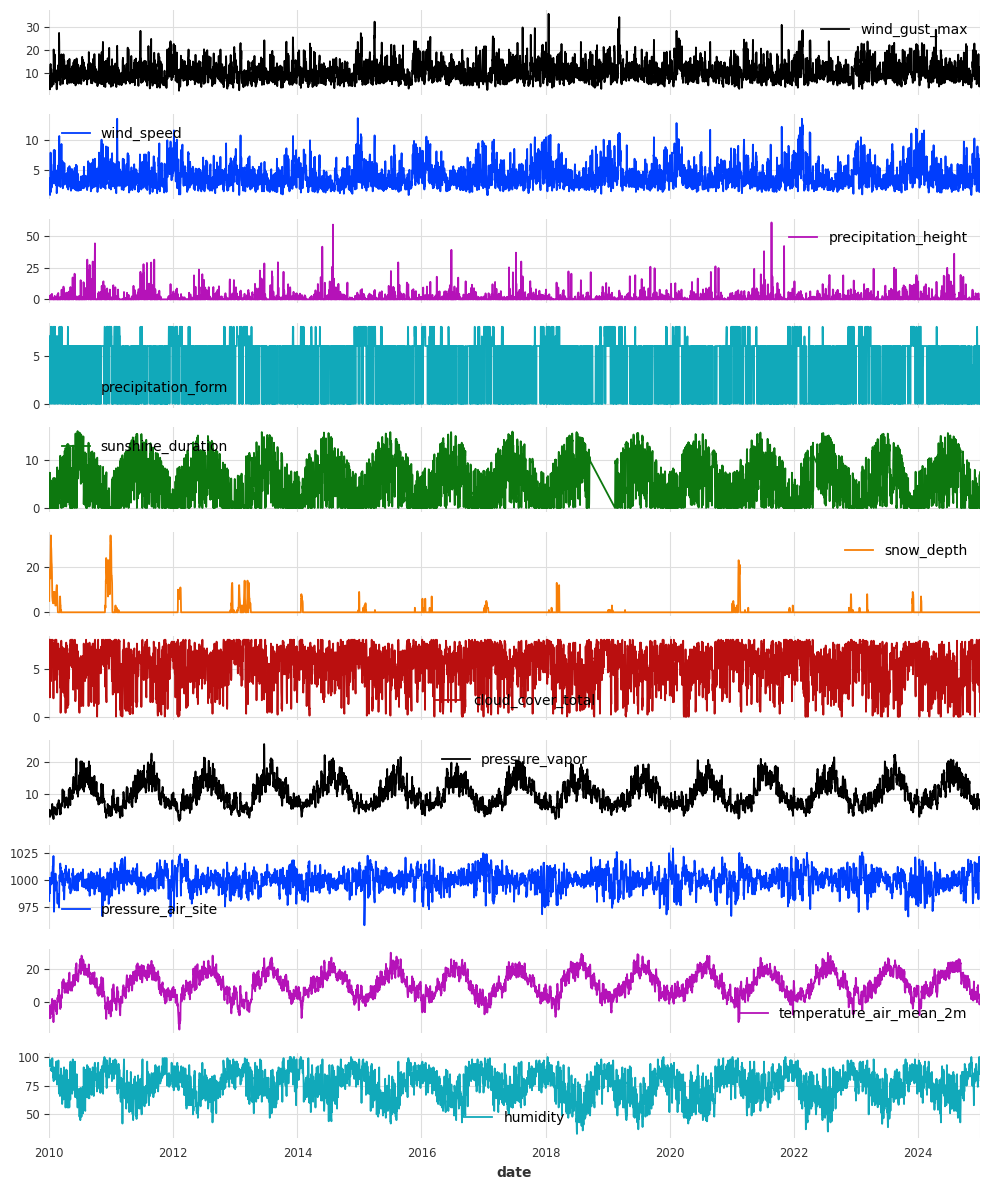

In [5]:
# Plot the last 15 years of each series to get an impression of the data
df.loc["2010":].plot(subplots=True, figsize=(10, 12))
plt.tight_layout()
plt.show()

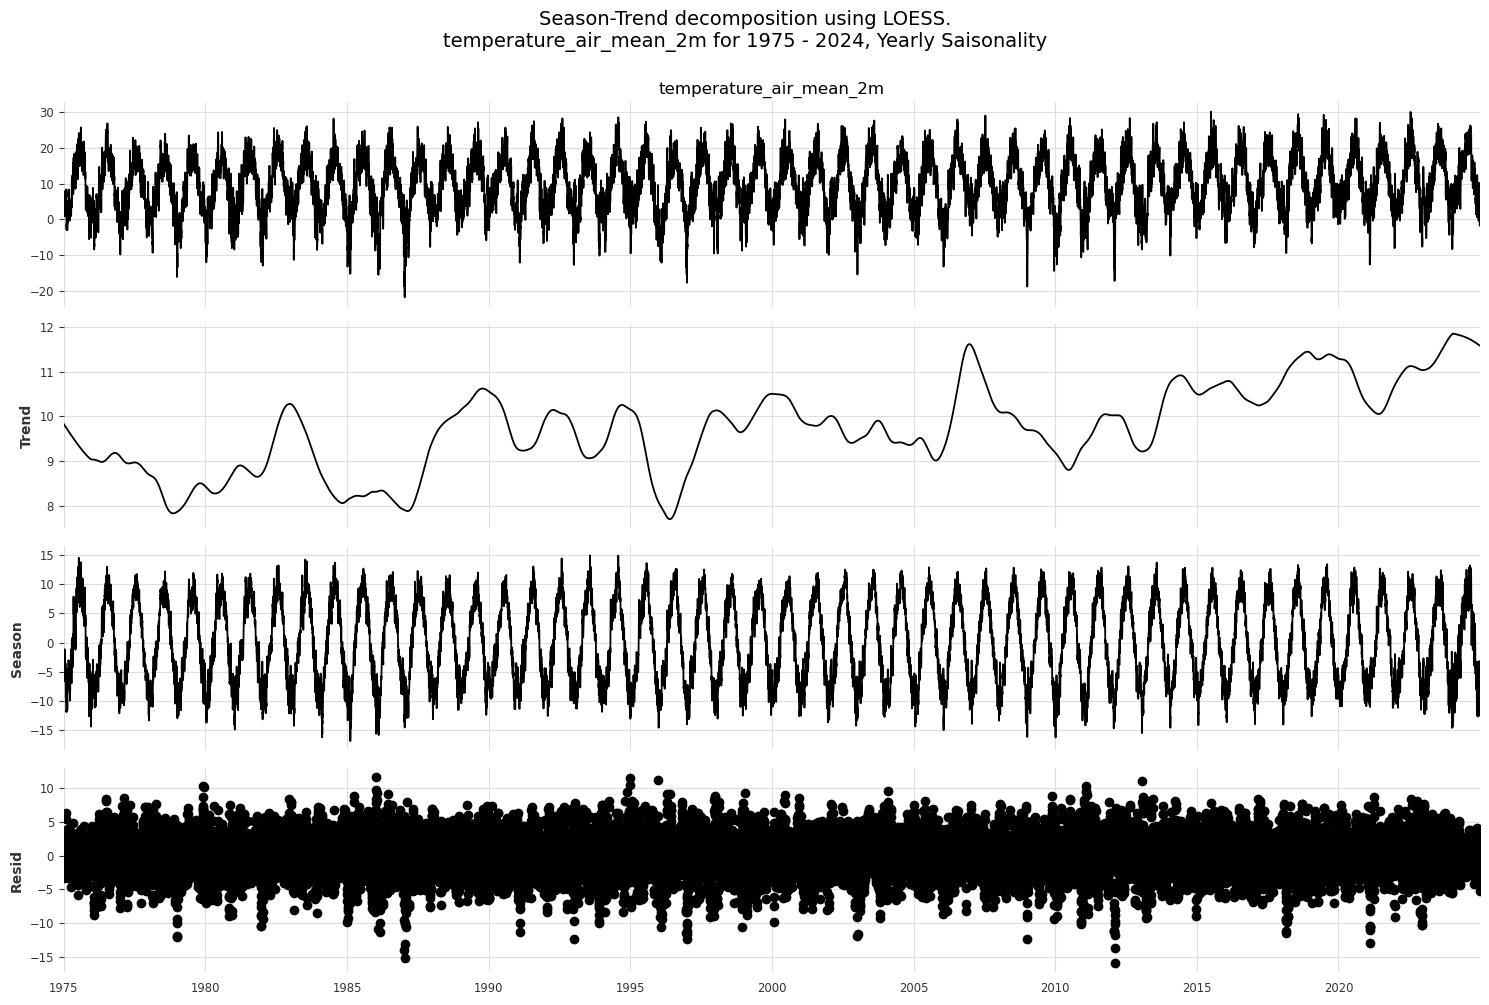

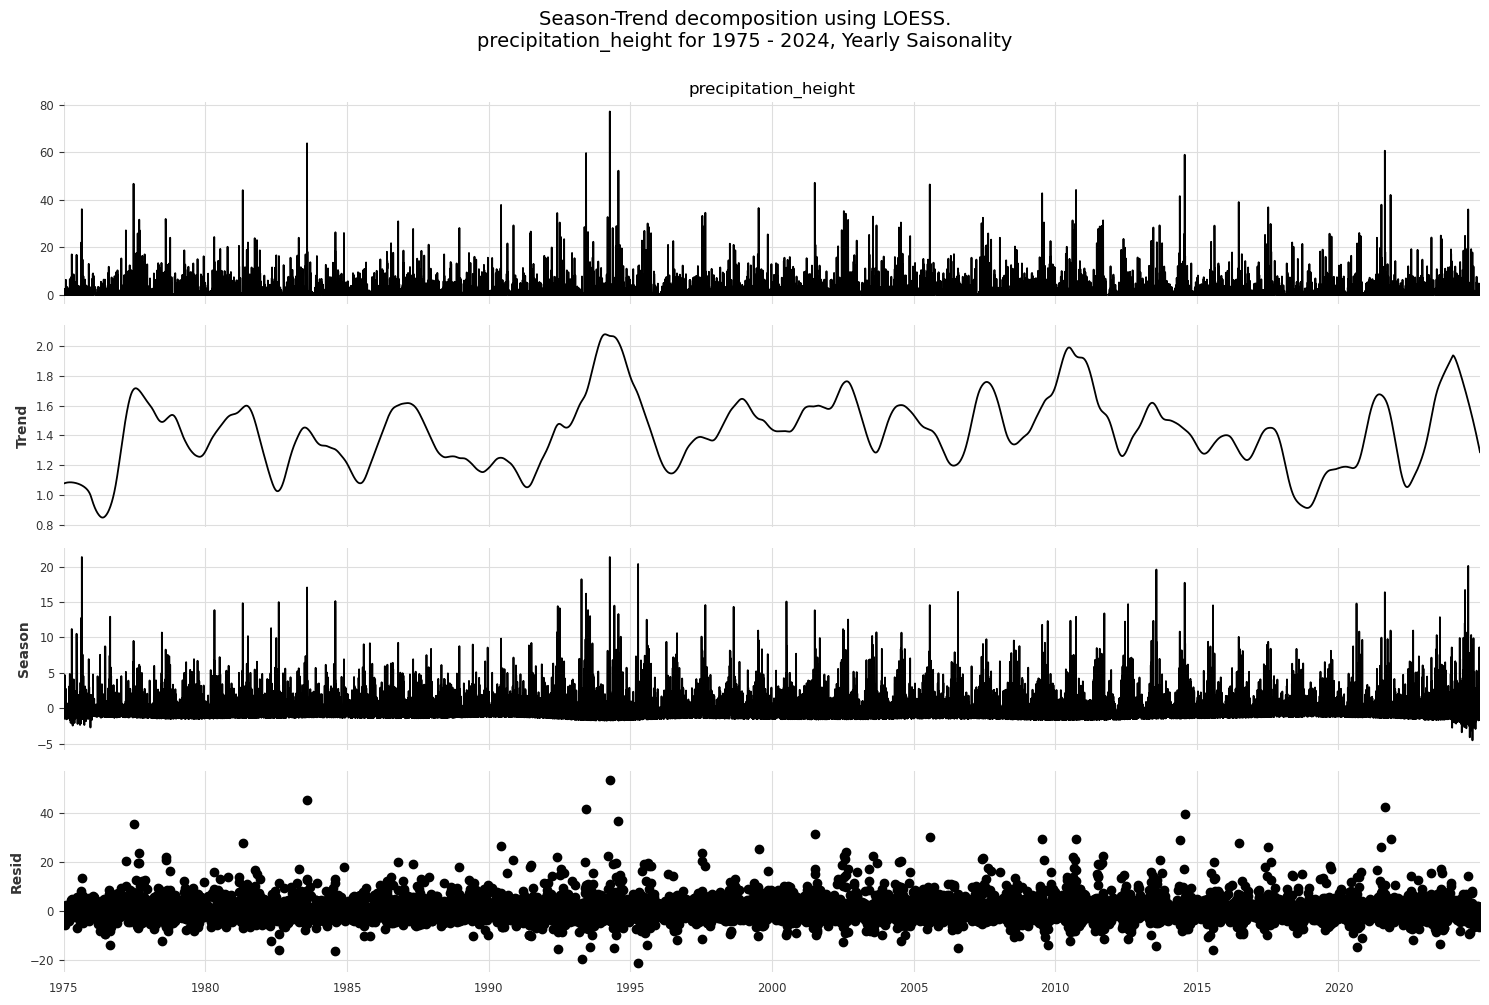

In [6]:
# Season-Trend decomposition using LOESS (STL)
from statsmodels.tsa.seasonal import STL

for col in ['temperature_air_mean_2m', 'precipitation_height']:
    stl_decomp_temp = STL(df[col], period=365).fit()
    stl_decomp_fig = stl_decomp_temp.plot()
    stl_decomp_fig.set_size_inches(15, 10)
    plt.suptitle(f"Season-Trend decomposition using LOESS.\n{col} for 1975 - 2024, Yearly Saisonality", y=1.0, fontsize=14)
    plt.tight_layout()
    plt.show()

## Correlation

Correlation tells us how features or variables move together over time. It’s useful for identifying potential dependencies between different time series or for selecting relevant covariates when using multivariate models.

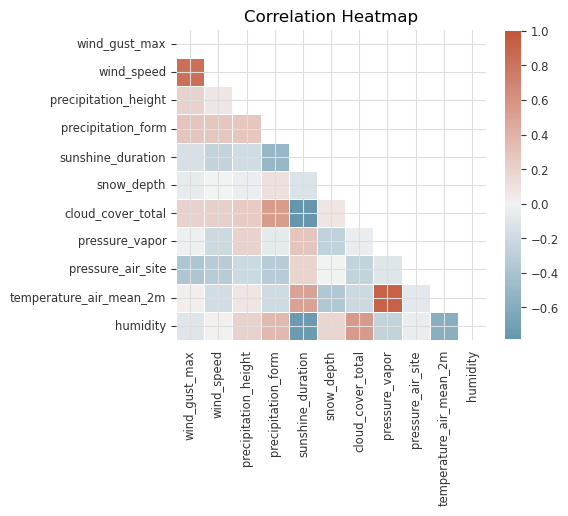

In [7]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(5, 8))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, ax=ax)
plt.title("Correlation Heatmap")
plt.show()

## Stationarity and Seasonality

Most statistical models assume stationarity — that the series has constant mean and variance over time. Seasonality, on the other hand, is a repeating pattern. This step helps us assess both properties to guide transformation or model choice.

In [8]:
# Double test on stationarity using Augmented Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin
from darts.utils.statistics import stationarity_tests

for col in df.columns:
    is_stationary = stationarity_tests(TimeSeries.from_series(df[col]), p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)
    print(f'{col} is stationary: {is_stationary}')

wind_gust_max is stationary: True
wind_speed is stationary: True
precipitation_height is stationary: True
precipitation_form is stationary: False
sunshine_duration is stationary: False
snow_depth is stationary: True
cloud_cover_total is stationary: True
pressure_vapor is stationary: True
pressure_air_site is stationary: True
temperature_air_mean_2m is stationary: True
humidity is stationary: False


In [9]:
# darts check_seasonality inferres potential seasonality period from the Autocorrelation Function (ACF)
from darts.utils.statistics import check_seasonality

# Collect seasonality info for each series
seas_dict = {}

for col in df.columns:
    seas_check = check_seasonality(TimeSeries.from_series(df[col]), max_lag=365, alpha=0.05)
    print(f'Seasonality check for {col}: {seas_check[0], seas_check[1]}')
    seas_dict[col] = seas_check

Seasonality check for wind_gust_max: (True, 20)
Seasonality check for wind_speed: (True, 15)
Seasonality check for precipitation_height: (True, 7)
Seasonality check for precipitation_form: (True, 8)
Seasonality check for sunshine_duration: (True, 10)
Seasonality check for snow_depth: (True, 326)
Seasonality check for cloud_cover_total: (True, 10)
Seasonality check for pressure_vapor: (True, 357)
Seasonality check for pressure_air_site: (True, 24)
Seasonality check for temperature_air_mean_2m: (True, 364)
Seasonality check for humidity: (True, 16)


## Autocorrelation

Autocorrelation shows how the current value of a time series is related to its past values. It’s essential for identifying lag dependencies, which are critical for models like ARIMA.

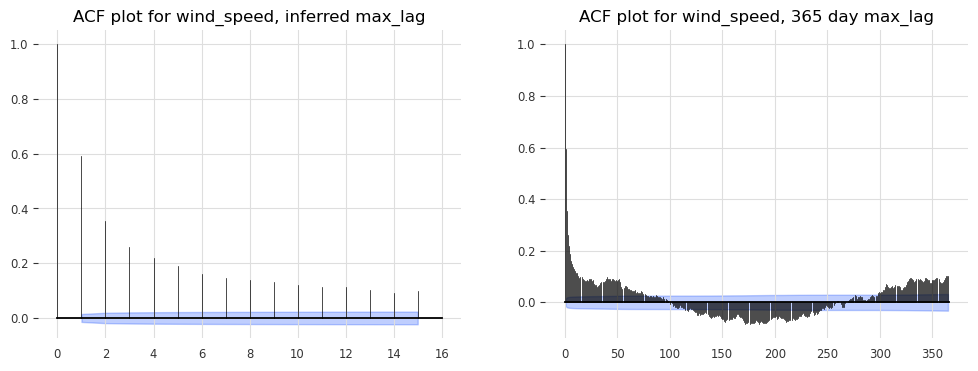

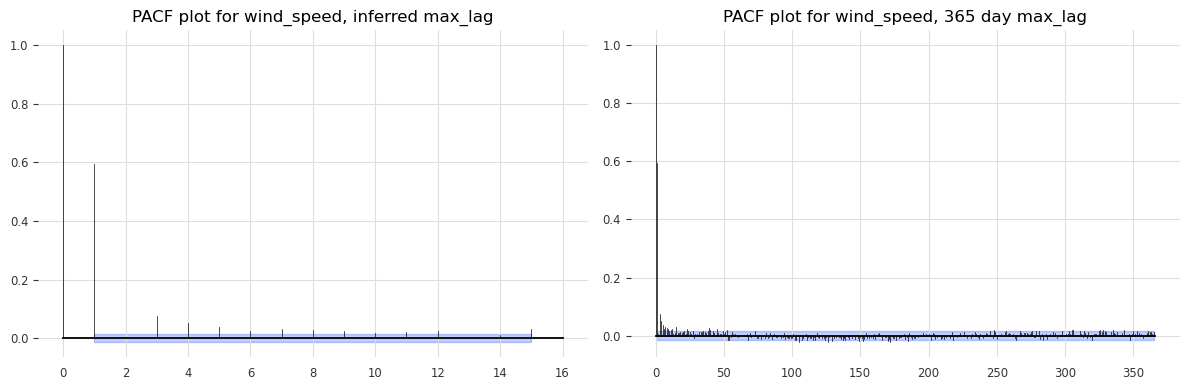

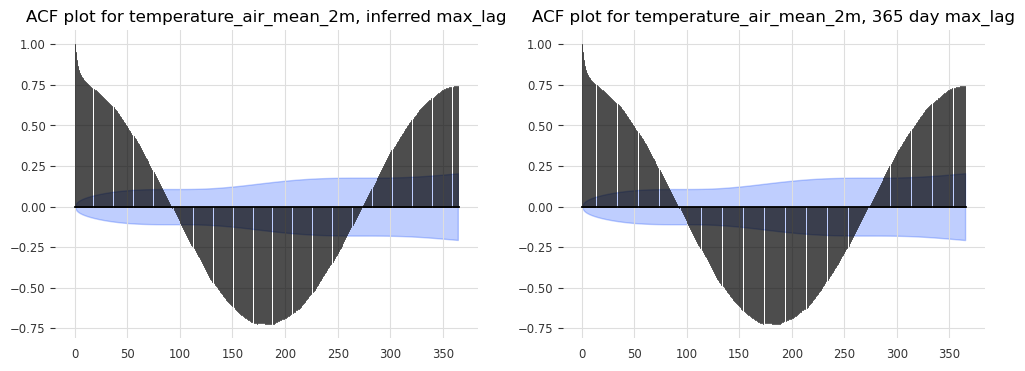

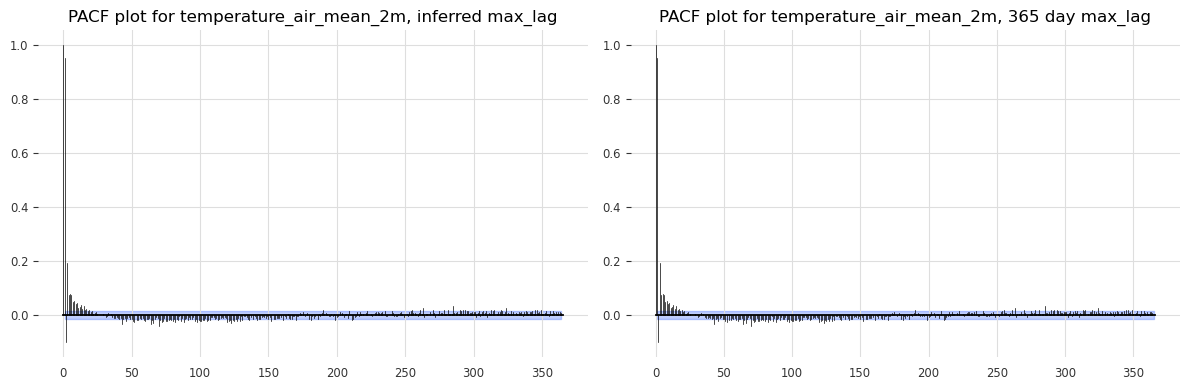

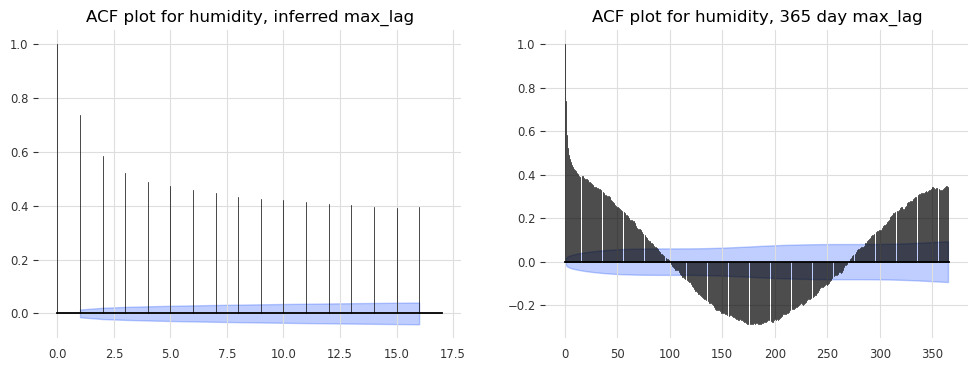

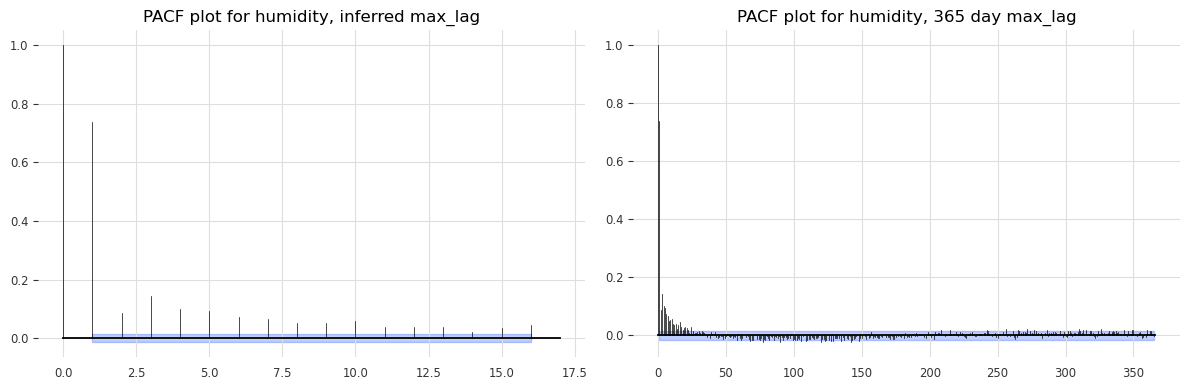

In [10]:
# Plot Autocorrelation Function (ACF) and Partial AutoCorrelation Function (PACF) for example series
# Use computed info about potential seasonality for max_lag values, compare with known period of 365 days
from darts.utils.statistics import plot_acf, plot_pacf

for col in df[['wind_speed', 'temperature_air_mean_2m', 'humidity']]:
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plot_acf(TimeSeries.from_series(df[col]), max_lag=seas_dict[col][1], alpha=0.05, axis=ax1)
    plot_acf(TimeSeries.from_series(df[col]), max_lag=365, alpha=0.05, axis=ax2)
    ax1.set_title(f'ACF plot for {col}, inferred max_lag')
    ax2.set_title(f'ACF plot for {col}, 365 day max_lag')
    fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plot_pacf(TimeSeries.from_series(df[col]), max_lag=seas_dict[col][1], alpha=0.05, axis=ax3)
    plot_pacf(TimeSeries.from_series(df[col]), max_lag=365, alpha=0.05, axis=ax4)
    ax3.set_title(f'PACF plot for {col}, inferred max_lag')
    ax4.set_title(f'PACF plot for {col}, 365 day max_lag')
    plt.tight_layout()
    plt.show()

## Residual analysis

Analyzing residuals helps us evaluate how well our decomposition or model captures structure, and whether additional components remain to be explained. After removing trend and seasonality, residuals show what’s left — ideally pure noise:
* No trend: The residuals fluctuate randomly around zero
* No seasonality: No repeating patterns or cycles
* Constant variance: The spread of the values doesn’t increase/decrease over time
* No autocorrelation: ACF/PACF plots show no significant lags (all bars within confidence bounds)
* Overall: Appears random, no structure, no bias

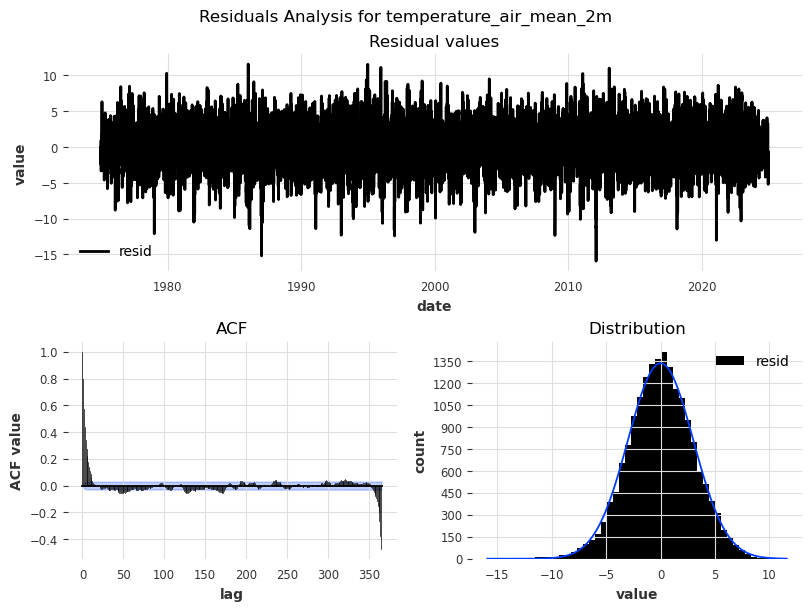

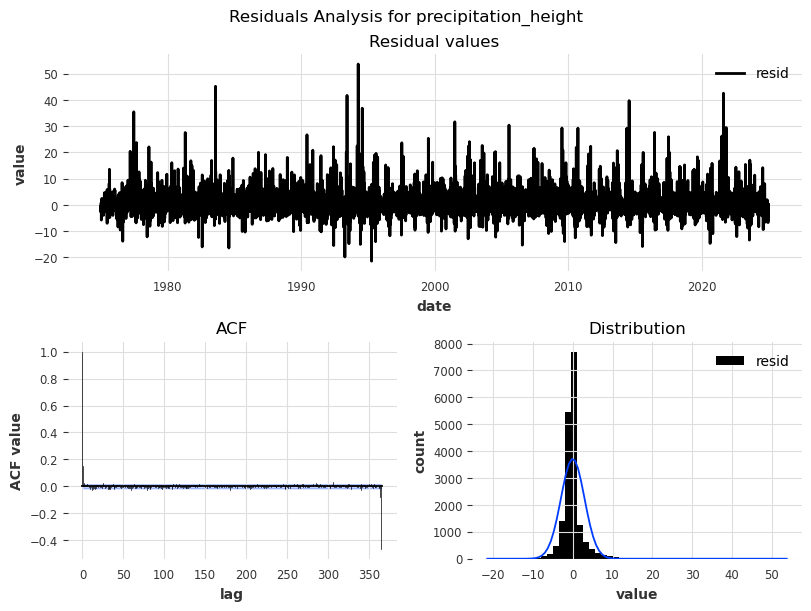

In [11]:
from darts.utils.statistics import plot_residuals_analysis

for col in df[['temperature_air_mean_2m', 'precipitation_height']]:
    residuals = STL(df[col], period=365).fit().resid
    plot_residuals_analysis(TimeSeries.from_series(residuals), num_bins=50, fill_nan=True, default_formatting=True, acf_max_lag=365)
    plt.suptitle(f'Residuals Analysis for {col}')
    plt.show()


## Save prepared series

In [12]:
df.to_csv("data/dwd_02932_climate_prepared.csv", sep=";", index=True)